In [194]:
# importing required libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import cophenet, linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist, pdist

In [195]:
# install openpyxl to read the xlsx files
import sys
!{sys.executable} -m pip install openpyxl

In [196]:
# Read the data from excel file using openpyxl as engine
cust_data = pd.read_excel('Credit Card Customer Data.xlsx', engine='openpyxl')
# Display the head of dataset
cust_data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### Insights:

`The data has rows at different measures which indicates that we should sclae the dataset`

In [197]:
# Look for shape of the data
cust_data.shape

(660, 7)

### Insights:

`There are 660 rows and 7 columns`

In [198]:
# Finding the type of each column
cust_data.dtypes

Sl_No                  int64
Customer Key           int64
Avg_Credit_Limit       int64
Total_Credit_Cards     int64
Total_visits_bank      int64
Total_visits_online    int64
Total_calls_made       int64
dtype: object

### Insights:

`All columns are of integer type`

In [199]:
# Check for rows with null value
cust_data.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Insights:

`The data set does not have any null values`

In [200]:
# Look for any duplicate records
cust_data.duplicated().sum()

0

### Insights:

`There are no duplicate records`

In [201]:
# Look for statistical summary of the data
cust_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


### Insights:

<ol>
<li> There are some customers who don't visit the bank, similarly we have customers that doesn't use online banking. Also there are customers who did not make a single call to the bank</li>
<br />

<li> By looking at mean and max values, it seems 'Avg_Credit_Limit' and 'Total_visits_online' has the data skewed right because the max value is far away from the mean</li>
    
</ol>

In [202]:
# Check for no. of unique values per column
cust_data.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

### Insights:

`The number of unique records between Sl_No and Customer Key are not matching which means Customer_key column has some records with same key value`

In [203]:
# Finding out records with duplicate Customer Keys
duplicate_customer_keys = cust_data.groupby('Customer Key').filter(lambda x: len(x) > 1 )
duplicate_customer_keys

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
4,5,47437,100000,6,0,12,3
48,49,37252,6000,4,0,2,8
104,105,97935,17000,2,1,2,10
332,333,47437,17000,7,3,1,0
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
411,412,50706,44000,4,5,0,2
432,433,37252,59000,6,2,1,2
541,542,50706,60000,7,5,2,2
632,633,97935,187000,7,1,7,0


### Insights:

<ol>
<li> There are 5 records with same customer keys 47437, 37252, 97935, 96929, 50706</li>
<br />

<li> These records indicates the behavioral change in customers (We can consider Sl_No value to find out which event happend first). For example, The customer with key 47437 initially (record with Sl_No: 5) has the credit limit of 100000, has 6 credit cards, never visited the bank, used online banking a lot, made calls to the bank sometimes. Later (SL_No with 333) the customer's credit limit decreased to 17000, applied one more credit card, started visting the bank in person, reduced the online usage and stopped calling  the bank</li>
<br />

<li> We can see similar behavioral changes in other customers with duplicate Customer Keys</li>
<br />

<li> These customers probabily start with one group and may be will move to different groups, hence these customers are ideal for Dynamic Clustering</li>
    
</ol>

In [204]:
# Take a copy of original dataframe
cust_data_copy = cust_data.copy()

# drop Sl_No and Customer Key columns in the copied dataframe
cust_data_copy.drop(['Sl_No', 'Customer Key'], axis=1, inplace=True)

### Insights:

` Dropped 'Sl_No' and 'Customer Key' columns as these values are unique for each row (with an exception of 5 records in case of Customer Key) and will not have an impact on the model`

# Univariate Analysis

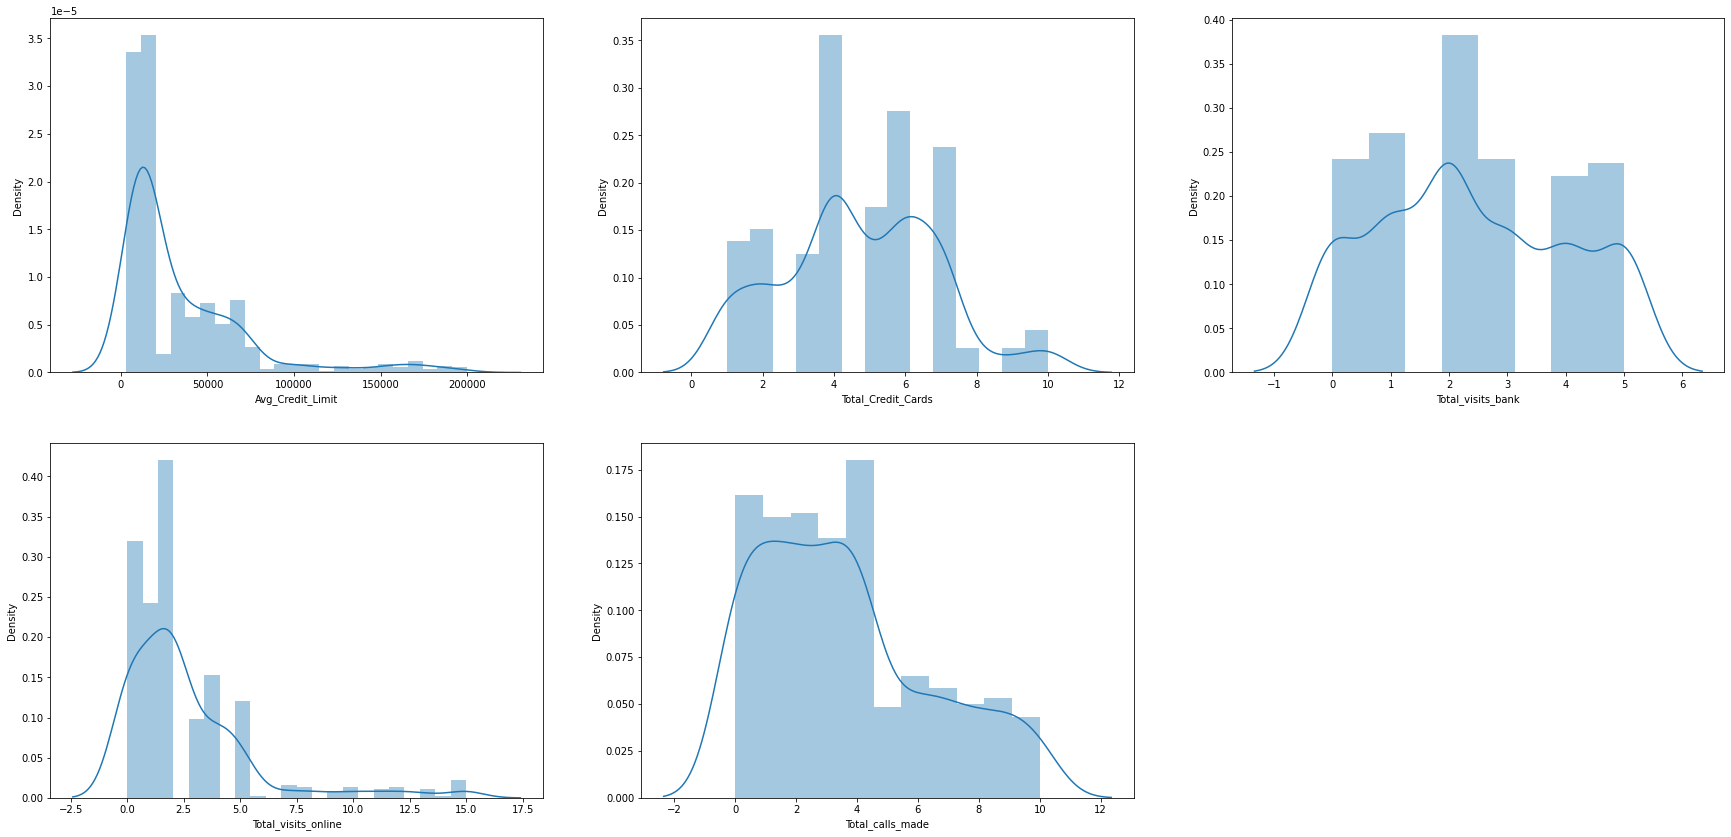

In [205]:
# Plot distribution plots for each column
def plot_univariate_graphs(df):
    plt.figure(figsize=(30,30))
    count=1
    for col in df.columns:
        plt.subplot(4,3,count)
        sns.distplot(df[col], kde=True)
        count+=1
    plt.show()
    
plot_univariate_graphs(cust_data_copy)

### Insights:

<ol>
<li> Avg_Credit_Limit and Total_visits_online has long tails on right side</li>
<br />

<li> Total_Credit_Cards and Total_visits_bank have more than one peak</li>
<br />

<li> Total_calls_made is approximately bell shaped with some right right skewed data</li>
</ol>

In [206]:
# Scale the data as Avg_Credit_Limit has different measure when compare to other columns
scaler = StandardScaler()
# scale the data and create a pandas dataframe
cust_data_scaled = pd.DataFrame(scaler.fit_transform(cust_data_copy), columns=cust_data_copy.columns)
cust_data_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


### Insights:

`All the data is now in the same scale`

# Bivariate Analysis

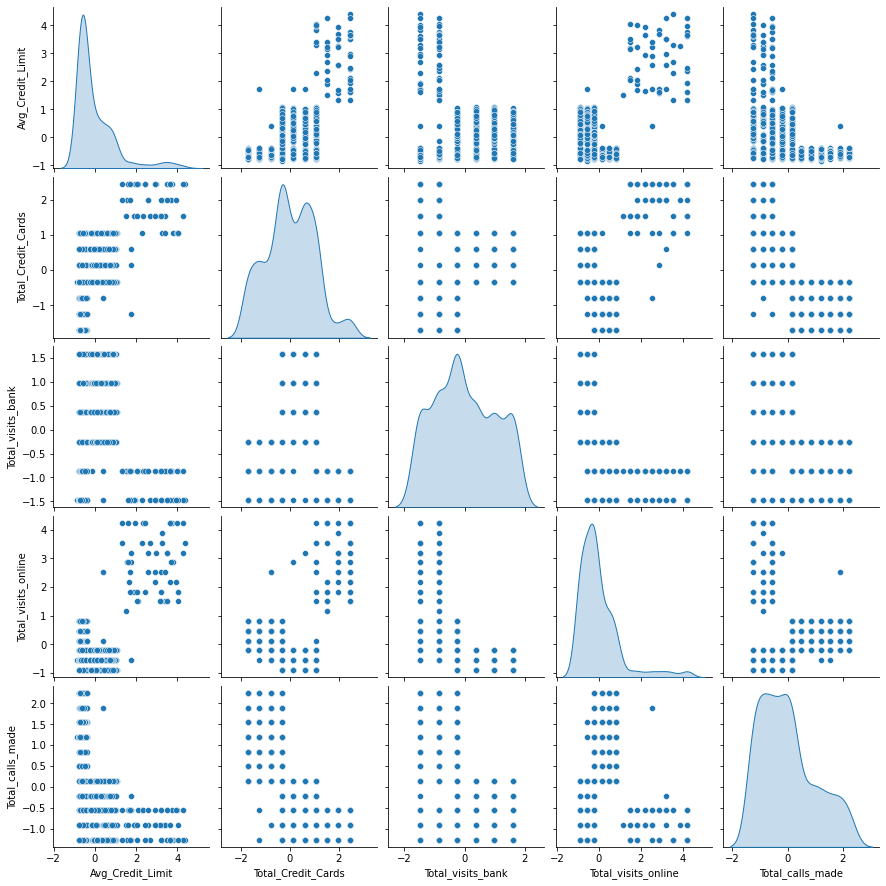

In [207]:
sns.pairplot(cust_data_scaled, diag_kind='kde')

### Insights:

` Based on our Univariate and Bivariate analysis, we can think of segmenting the customers in to 3 groups depending upon their mode of contact (Customers who visits the bank, visits online and makes phone calls) with the bank or we could segment the customers based on their credit limit (High, medium and low)`

# K-Means Clustering

In [208]:
# The evaluate_kmeans function does the following:

#    1. Takes the dataframe as input
#    2. Evalute different KMeans cluster models at each k value ranging from 1 to 9
#    3. Calculates mean distoritons per each k
#    4. Returns no of clusters and list of mean distortions

def evaluate_kmeans(df):
    no_clusters = range(1, 10)
    mean_distortions = []
    
    for k in no_clusters:
        kmc = KMeans(n_clusters=k, random_state=7)
        kmc.fit(df)
        # Find the distance b/w each point and the model cluster centroid. Take the minimum distance
        centroid_to_points_dist = np.min(cdist(df, kmc.cluster_centers_, 'euclidean'), axis=1)
        # Calculate the mean distortion
        mean_distortion = (sum (centroid_to_points_dist)) / len(df)
        # append the mean distortion to the mean_distortions list
        mean_distortions.append(mean_distortion)
    return no_clusters, mean_distortions

In [209]:
# The below function draws the elbow graph between k value and the mean distortions
def draw_elbow_plot(no_clusters, distortions):
    plt.figure(figsize=(10,7))
    plt.plot(no_clusters, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average distortion')
    plt.title('Selecting k with the Elbow Method')

[2.0069222262503614, 1.4571553548514269, 1.1466276549150365, 1.0463825294774465, 0.9907383936093271, 0.9429753673519395, 0.9094176768725913, 0.8899781320923997, 0.8673662789777815]


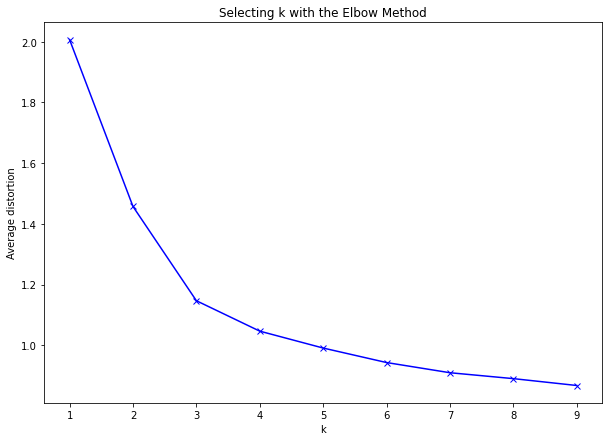

In [210]:
# Evalutae KMeans Clustering algorithm at different K, get the mean distortions and plot the elbow graph
no_clusters, mean_distortions = evaluate_kmeans(cust_data_scaled)
# Print the mean distortions list
print(mean_distortions)
draw_elbow_plot(no_clusters, mean_distortions)


### Insights:

`As we thought from univariate and bivariate analysis, we can see from the above elbow graph that there is no significant drop of mean distortion for k >3. So we can consider K as 3`

In [211]:
# Create KMeans cluster model with 3 clusters using the scaled data
kmc = KMeans(n_clusters=3, random_state=7)
kmc.fit(cust_data_scaled)

# Assign kmeans cluster labels to copied non scaled dataframe and to scaled dataframe
cust_data_copy['kmc_label'] = kmc.labels_
cust_data_scaled['kmc_label'] = kmc.labels_
# View the head elements with labels
cust_data_copy.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,kmc_label
0,100000,2,1,1,0,0
1,50000,3,0,10,9,1
2,50000,7,1,3,4,0
3,30000,5,1,1,4,0
4,100000,6,0,12,3,2


### Insights:

`KMeans labeled the data in to 3 segments 0, 1 and 2. Lets find out what these labels mean by plotting the box plot`

# Boxplot of KMeans cluster

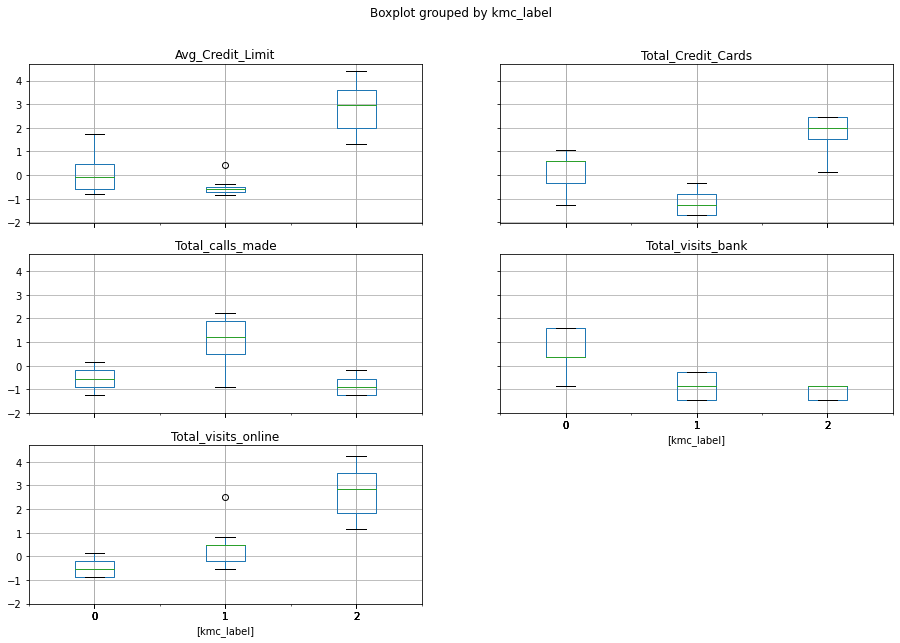

In [212]:
# Plot the boxplot by grouping the kmc_label column in scaled dataframe
cust_data_scaled.boxplot(by='kmc_label', figsize=(15,10))
plt.show()

### Insights:

<ol>
<li> Customers who uses online quite a lot(those belong to label 2) are the ones that has higher credit limit, has higher number of credit cards. They make phone calls to the bank less of number of times compared other customers and visits bank very rarely.</li>
<br/>

<li> Customers who makes phone calls a lot(those belong to label 1) are the ones with less credit limit, has low number of credit cards. They visit online and bank sometimes.</li>
<br/>

<li>Customers who visits the bank more often(those belong to lable 0) are the ones with medium range of credit limit, medium number of credit cards. They use online facility very less and makes phone calls sometimes.</li>

</ol>

# 3D - Visualization

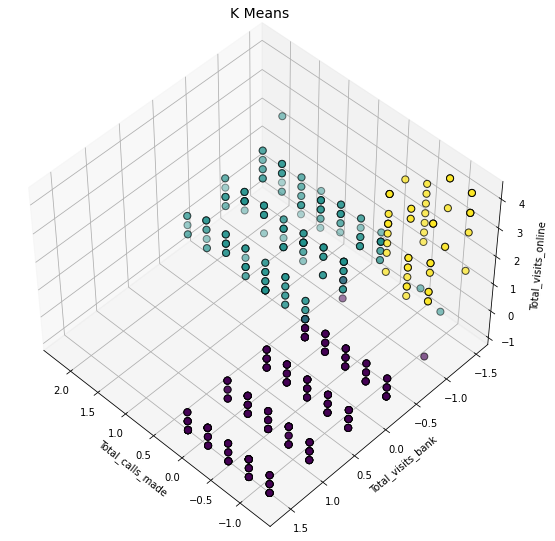

In [213]:
# Visualize the data in 3D
fig = plt.figure(1, figsize=(10,7))
ax = Axes3D(fig, rect=[0,0,0.95,1], elev=48, azim=134)
ax.scatter(cust_data_scaled['Total_calls_made'], 
               cust_data_scaled['Total_visits_bank'], 
               cust_data_scaled['Total_visits_online'], 
               c=cust_data_scaled['kmc_label'].astype(np.float), 
               edgecolors='k', s=50)
ax.set_xlabel("Total_calls_made")
ax.set_ylabel("Total_visits_bank")
ax.set_zlabel("Total_visits_online")
plt.title("K Means", fontsize=14)
plt.show()

# Scatter Plot between Avg Credit Limit and Total credit cards

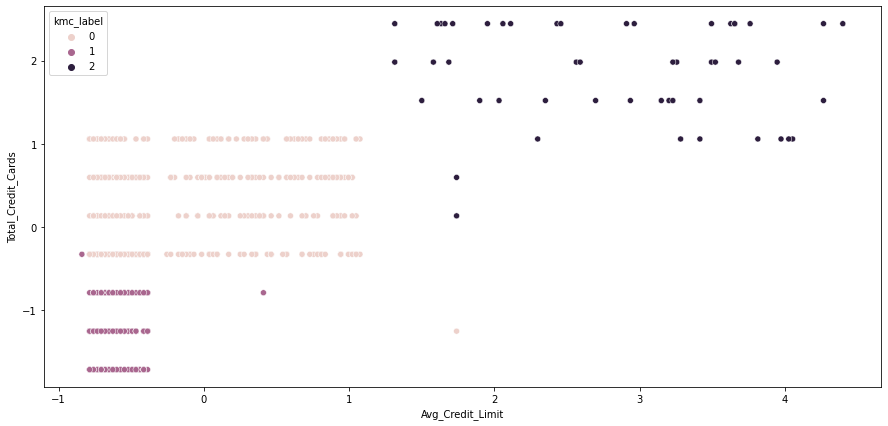

In [214]:
plt.figure(figsize=(15, 7))
# Plot the scatter plot b/w average credit limit and total number of credit cards with kmc_label as hue
sns.scatterplot(data=cust_data_scaled, x='Avg_Credit_Limit', y='Total_Credit_Cards', hue='kmc_label')
plt.show()

### Insights:

`By Looking at the 3D plot and 2D scatter plot, KMeans clustering algorithm did a good job in segmenting the customers into clusters with minor overlap points between the cluster`

# KMeans Silhouette Score

In [215]:
# Find the silhouette score
# Drop the labels from scaled dataframe and assign to X
X = cust_data_scaled.drop('kmc_label', axis=1)
labels = cust_data_scaled['kmc_label']
# Create results dataframe to capture the silhouette score per model
results_df = pd.DataFrame(columns=['silhouette score'])
# Calculate the silhouette score and assign it to results dataframe silhouette column and model name as index
results_df.loc['KMeans Cluster'] = [silhouette_score(X, labels, metric='euclidean',  random_state=7)]
results_df

,silhouette score
KMeans Cluster,0.515718


### Insights:

`The model is very good if the silhouette score is close to 1. In our case the socre is 0.515718, so the model performed good`

# Hierarchial Clustering

In [216]:
# The perform_hierarchial_clustering function does the following:

#   1. Takes dataframe, metric and list of linkage_methods as inputs
#   2. For each linkage method, it finds the linkage matrix and cophenetic correlation
#   3. returns linkage_matrix list and a dataframe with cophenetic correlation for each linkage method 

def perform_hierarchial_clustering(df, metric, linkage_methods):
    cophenet_corr_df = pd.DataFrame(columns=['Cophenetic Correlation'])
    linkage_matrix_per_linkage_method = []
    for method in linkage_methods:
        linkage_matrix = linkage(df, metric=metric, method=method)
        correlation, coph_dist = cophenet(linkage_matrix, pdist(df))
        
        linkage_matrix_per_linkage_method.append({
                                                   'method': method,
                                                   'linkage_matrix': linkage_matrix,
                                                   'correlation': correlation
                                                })
        method_name = 'Hierarchial Clustering with {} linkage Method'.format(method)
        cophenet_corr_df.loc[method_name] = [correlation]
        
    return linkage_matrix_per_linkage_method, cophenet_corr_df

In [217]:
# Create list of linkage methods
linkage_methods = ['single', 'complete', 'average', 'centroid','ward']

# Execute the perform_hierarchial_clusetring method by passing the scaled data, metric as 'euclidean' and list of 
# linkage methods defined above
linkage_matrix_list, cophenet_corr_df  = perform_hierarchial_clustering(X, 
                                                                    'euclidean', 
                                                                    linkage_methods)

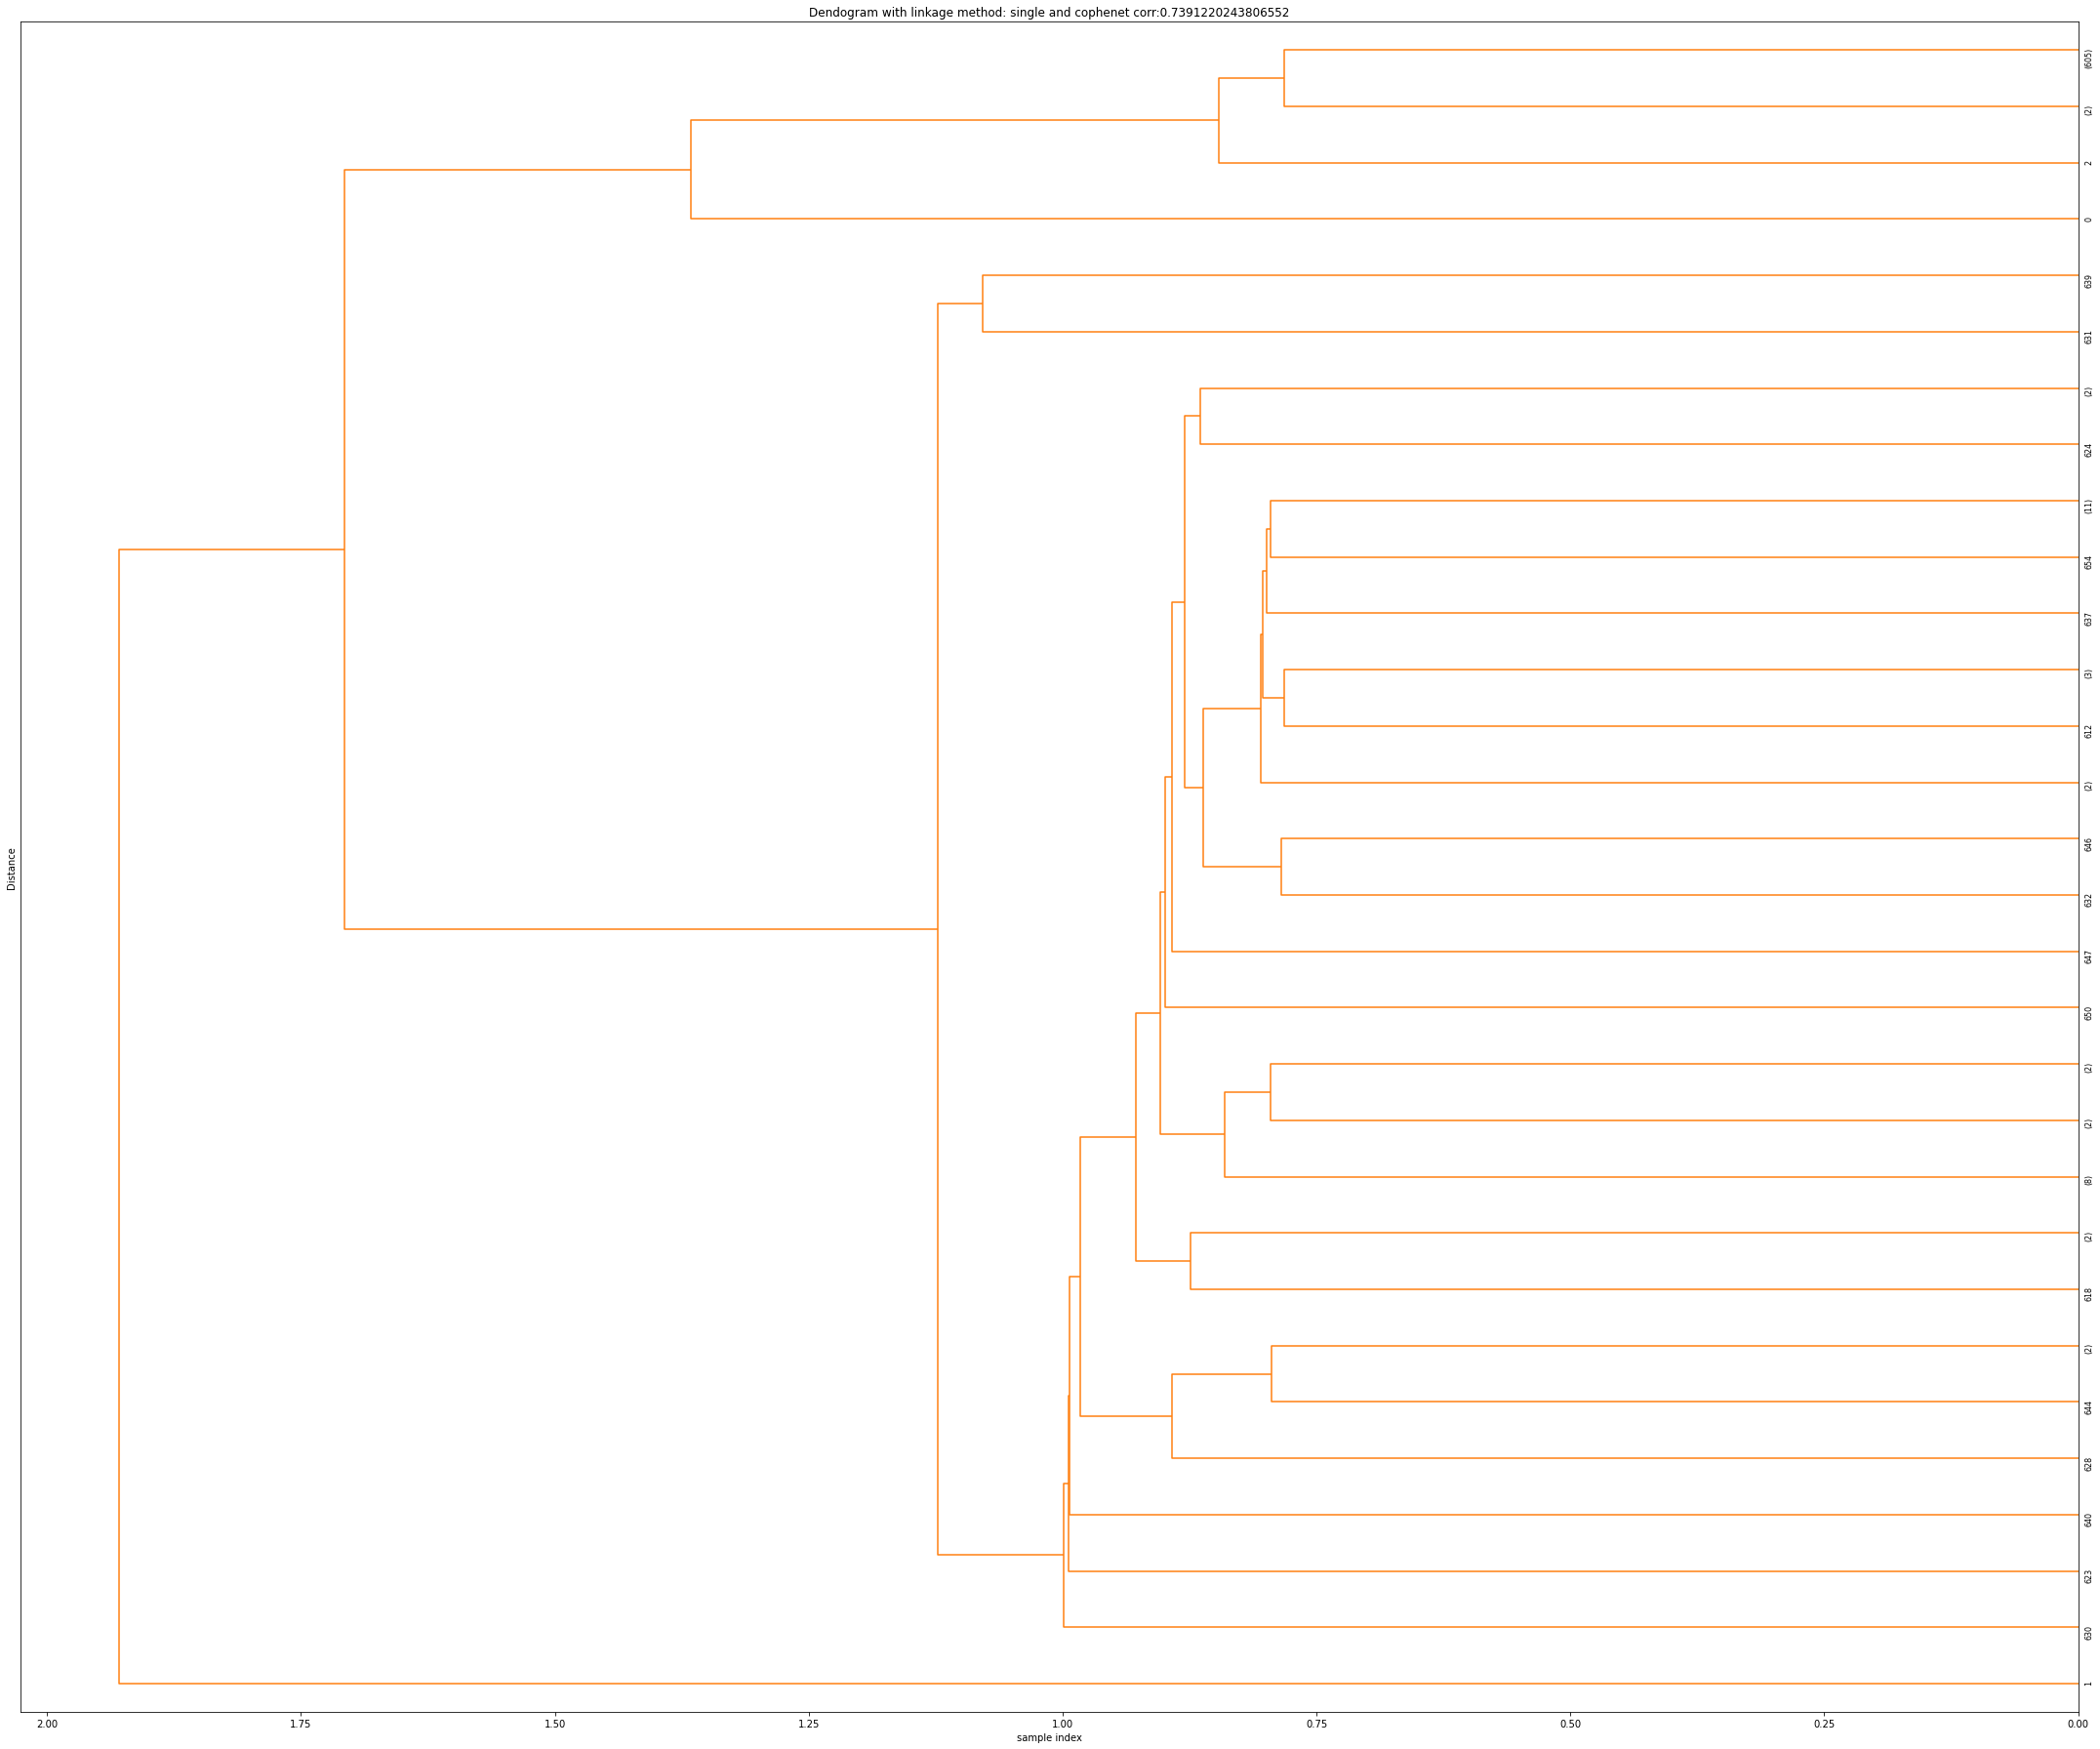

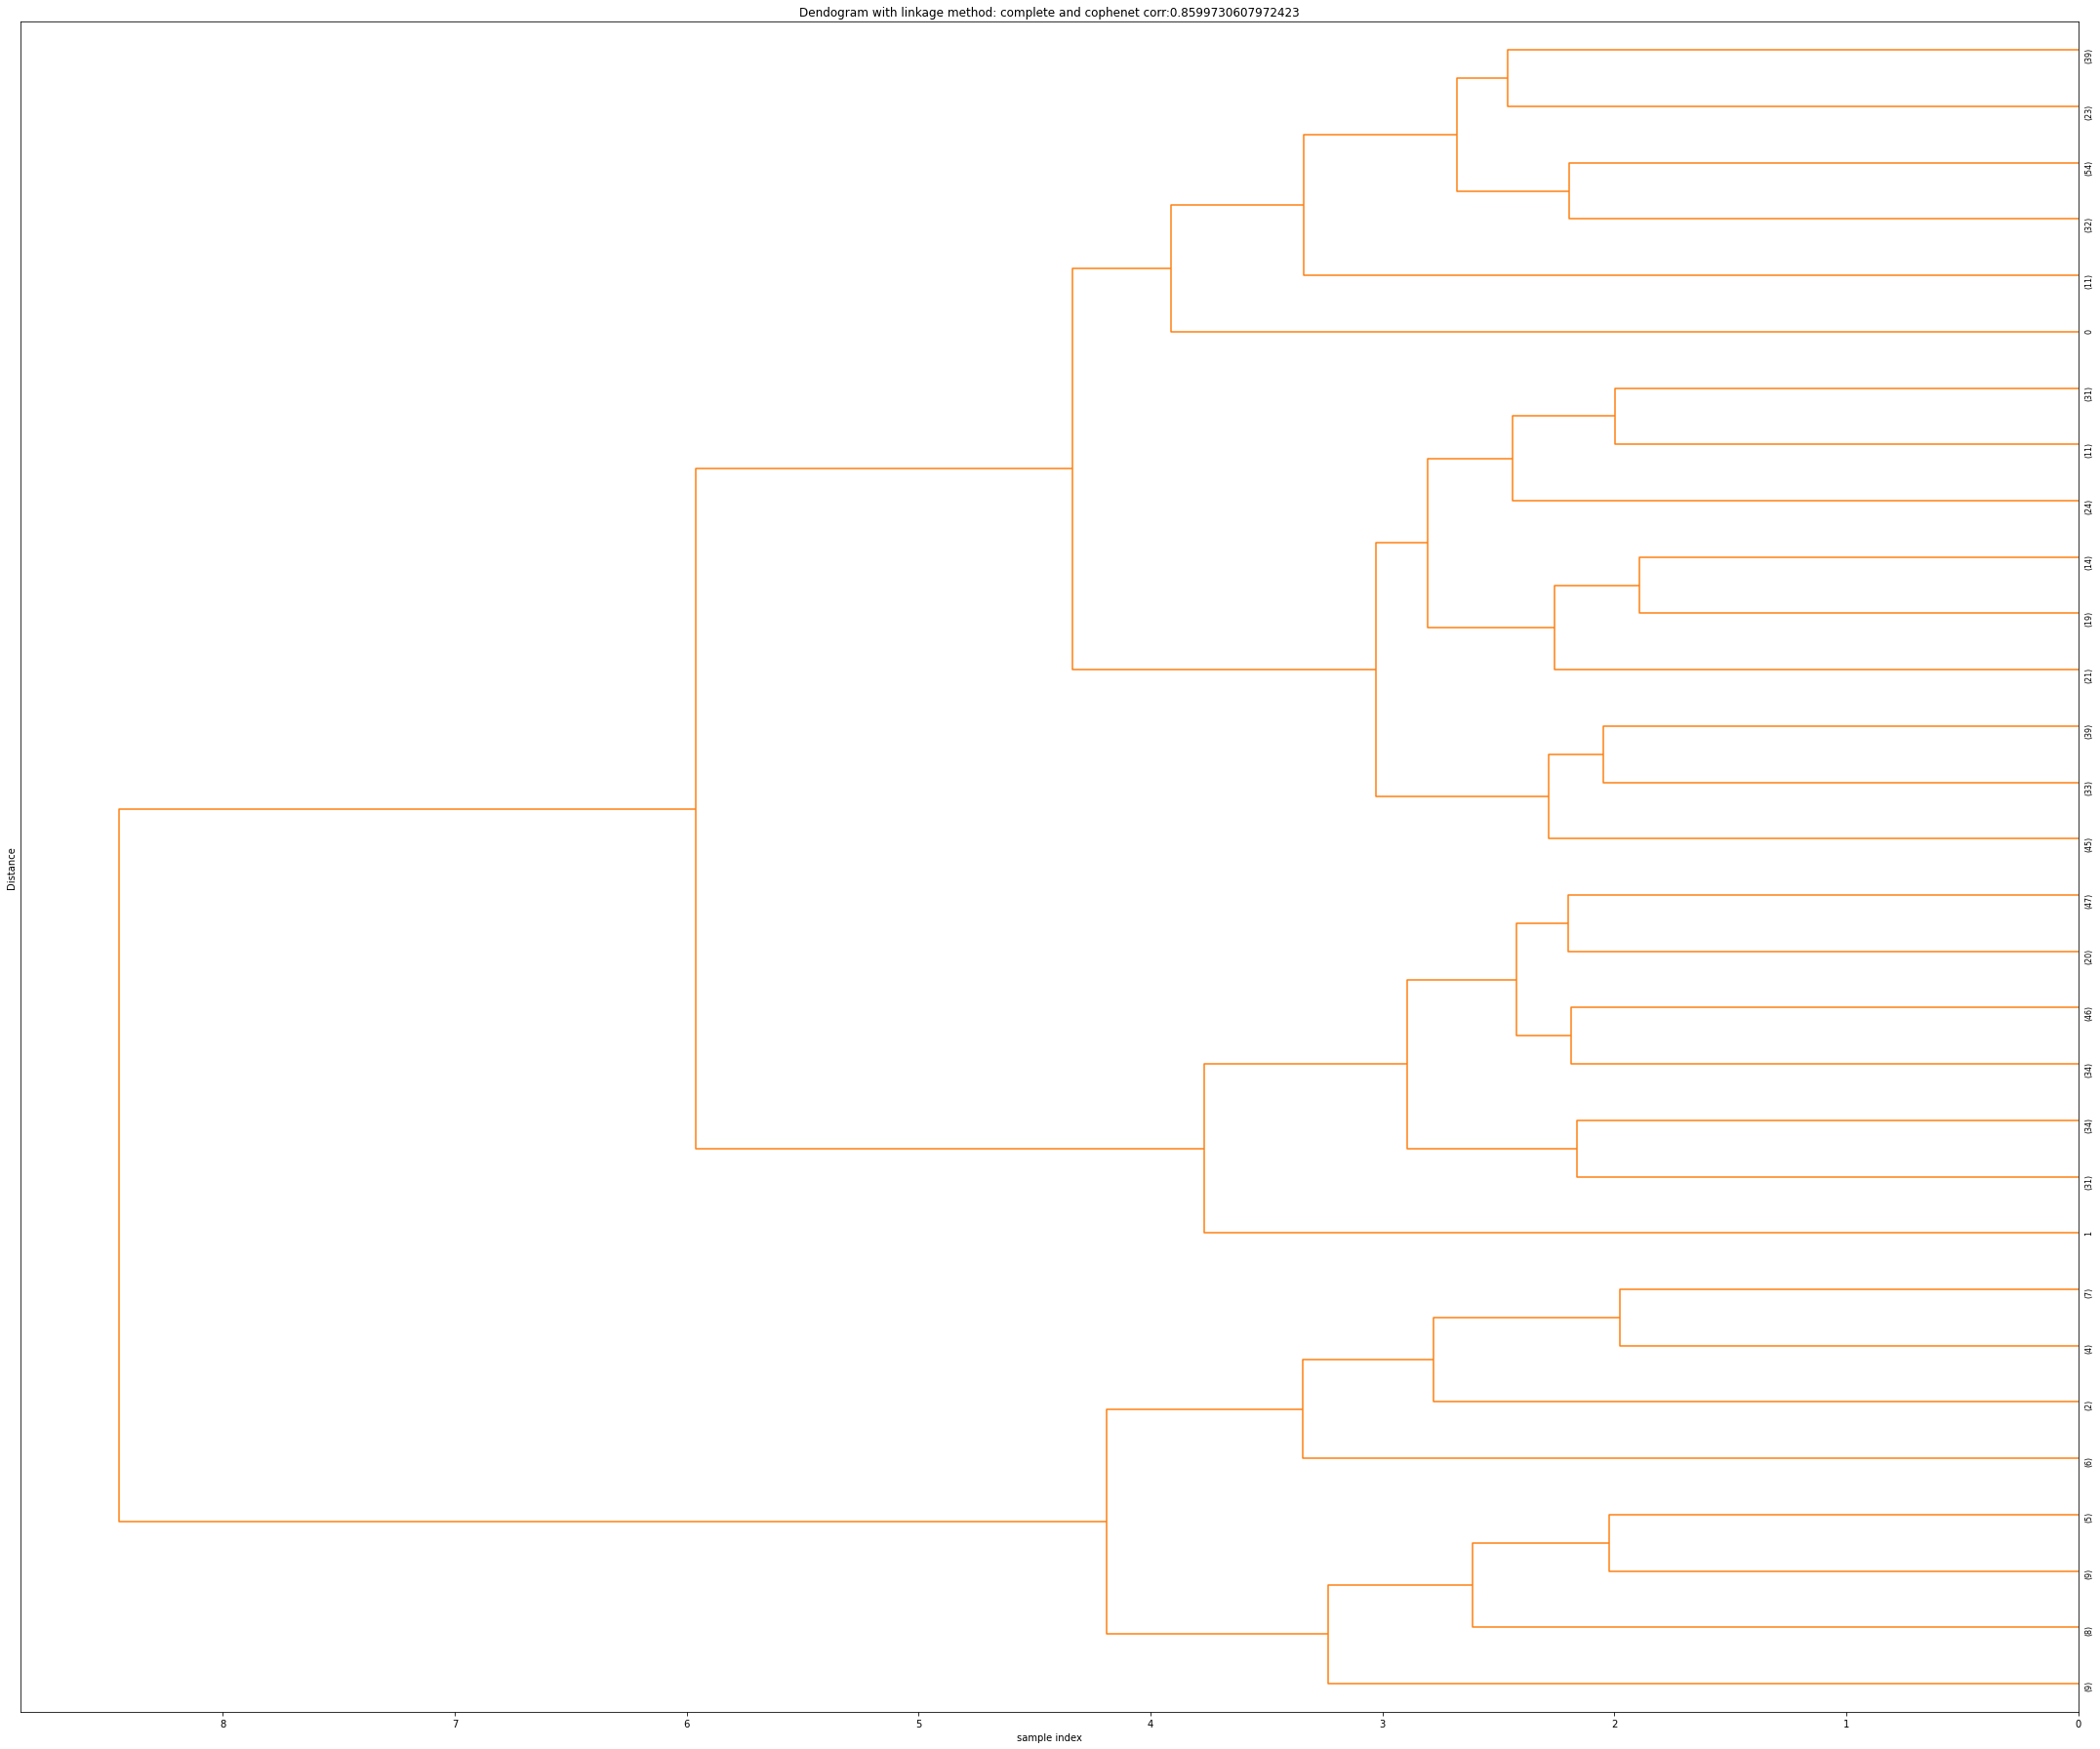

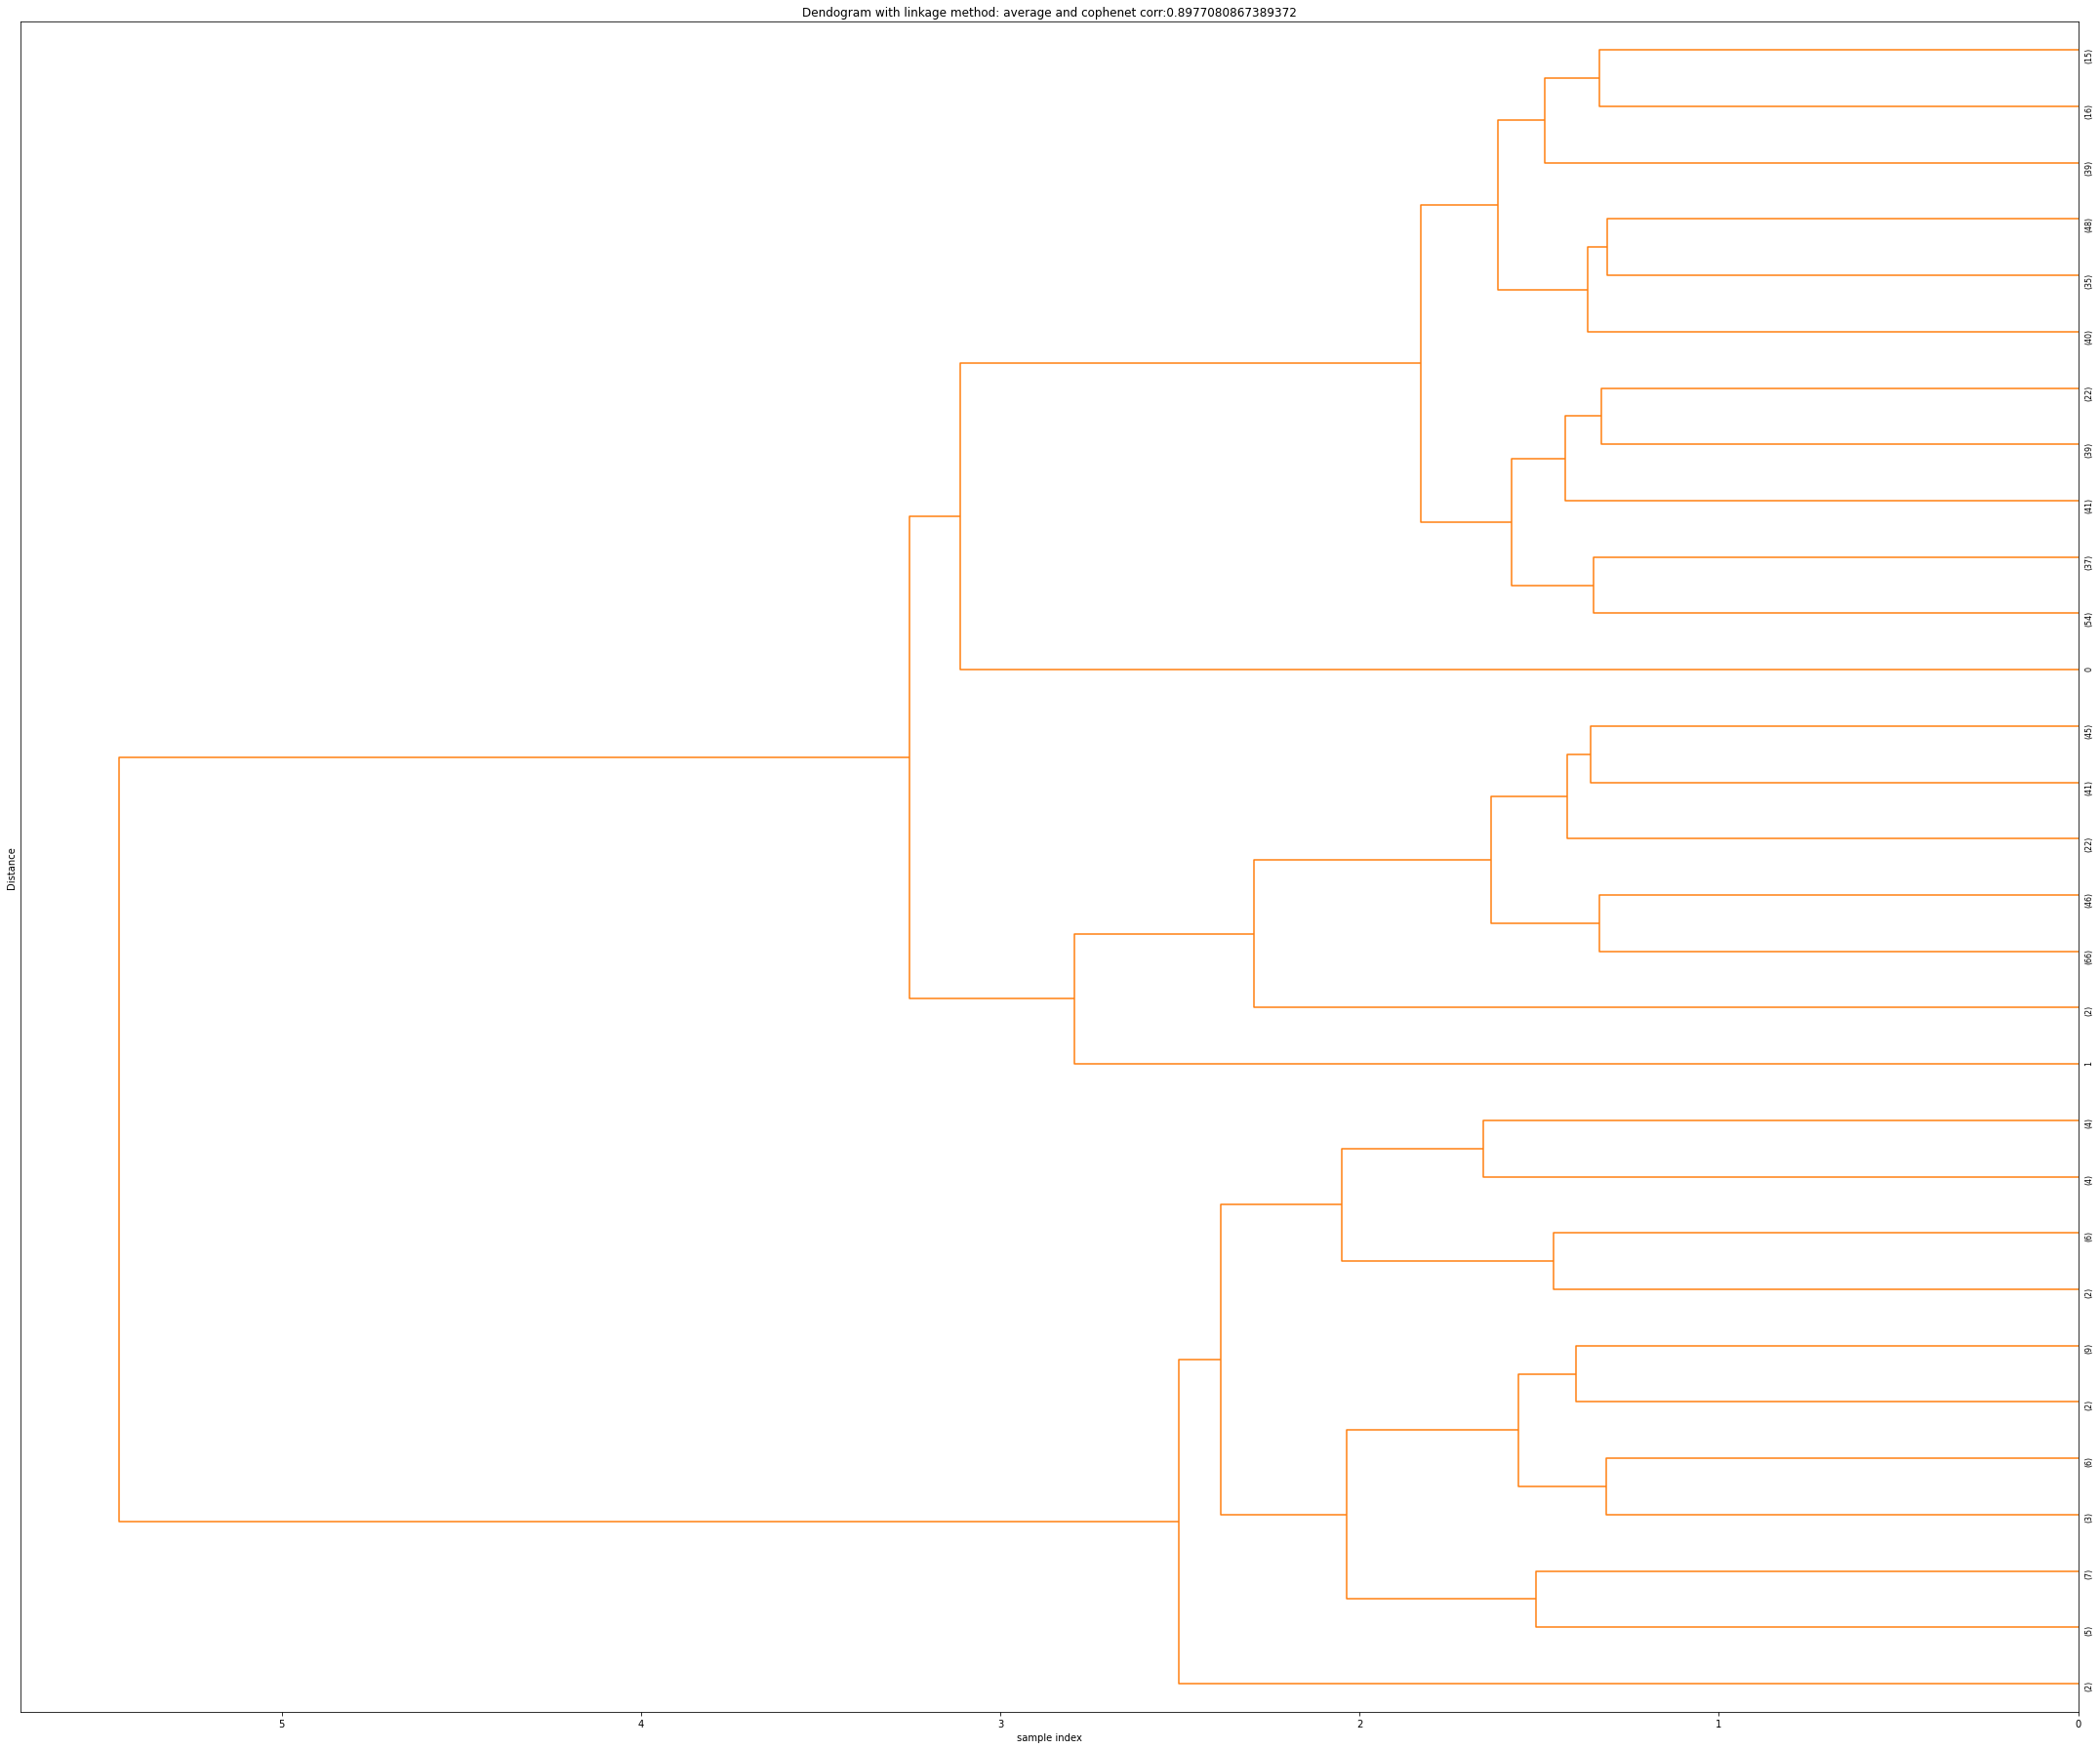

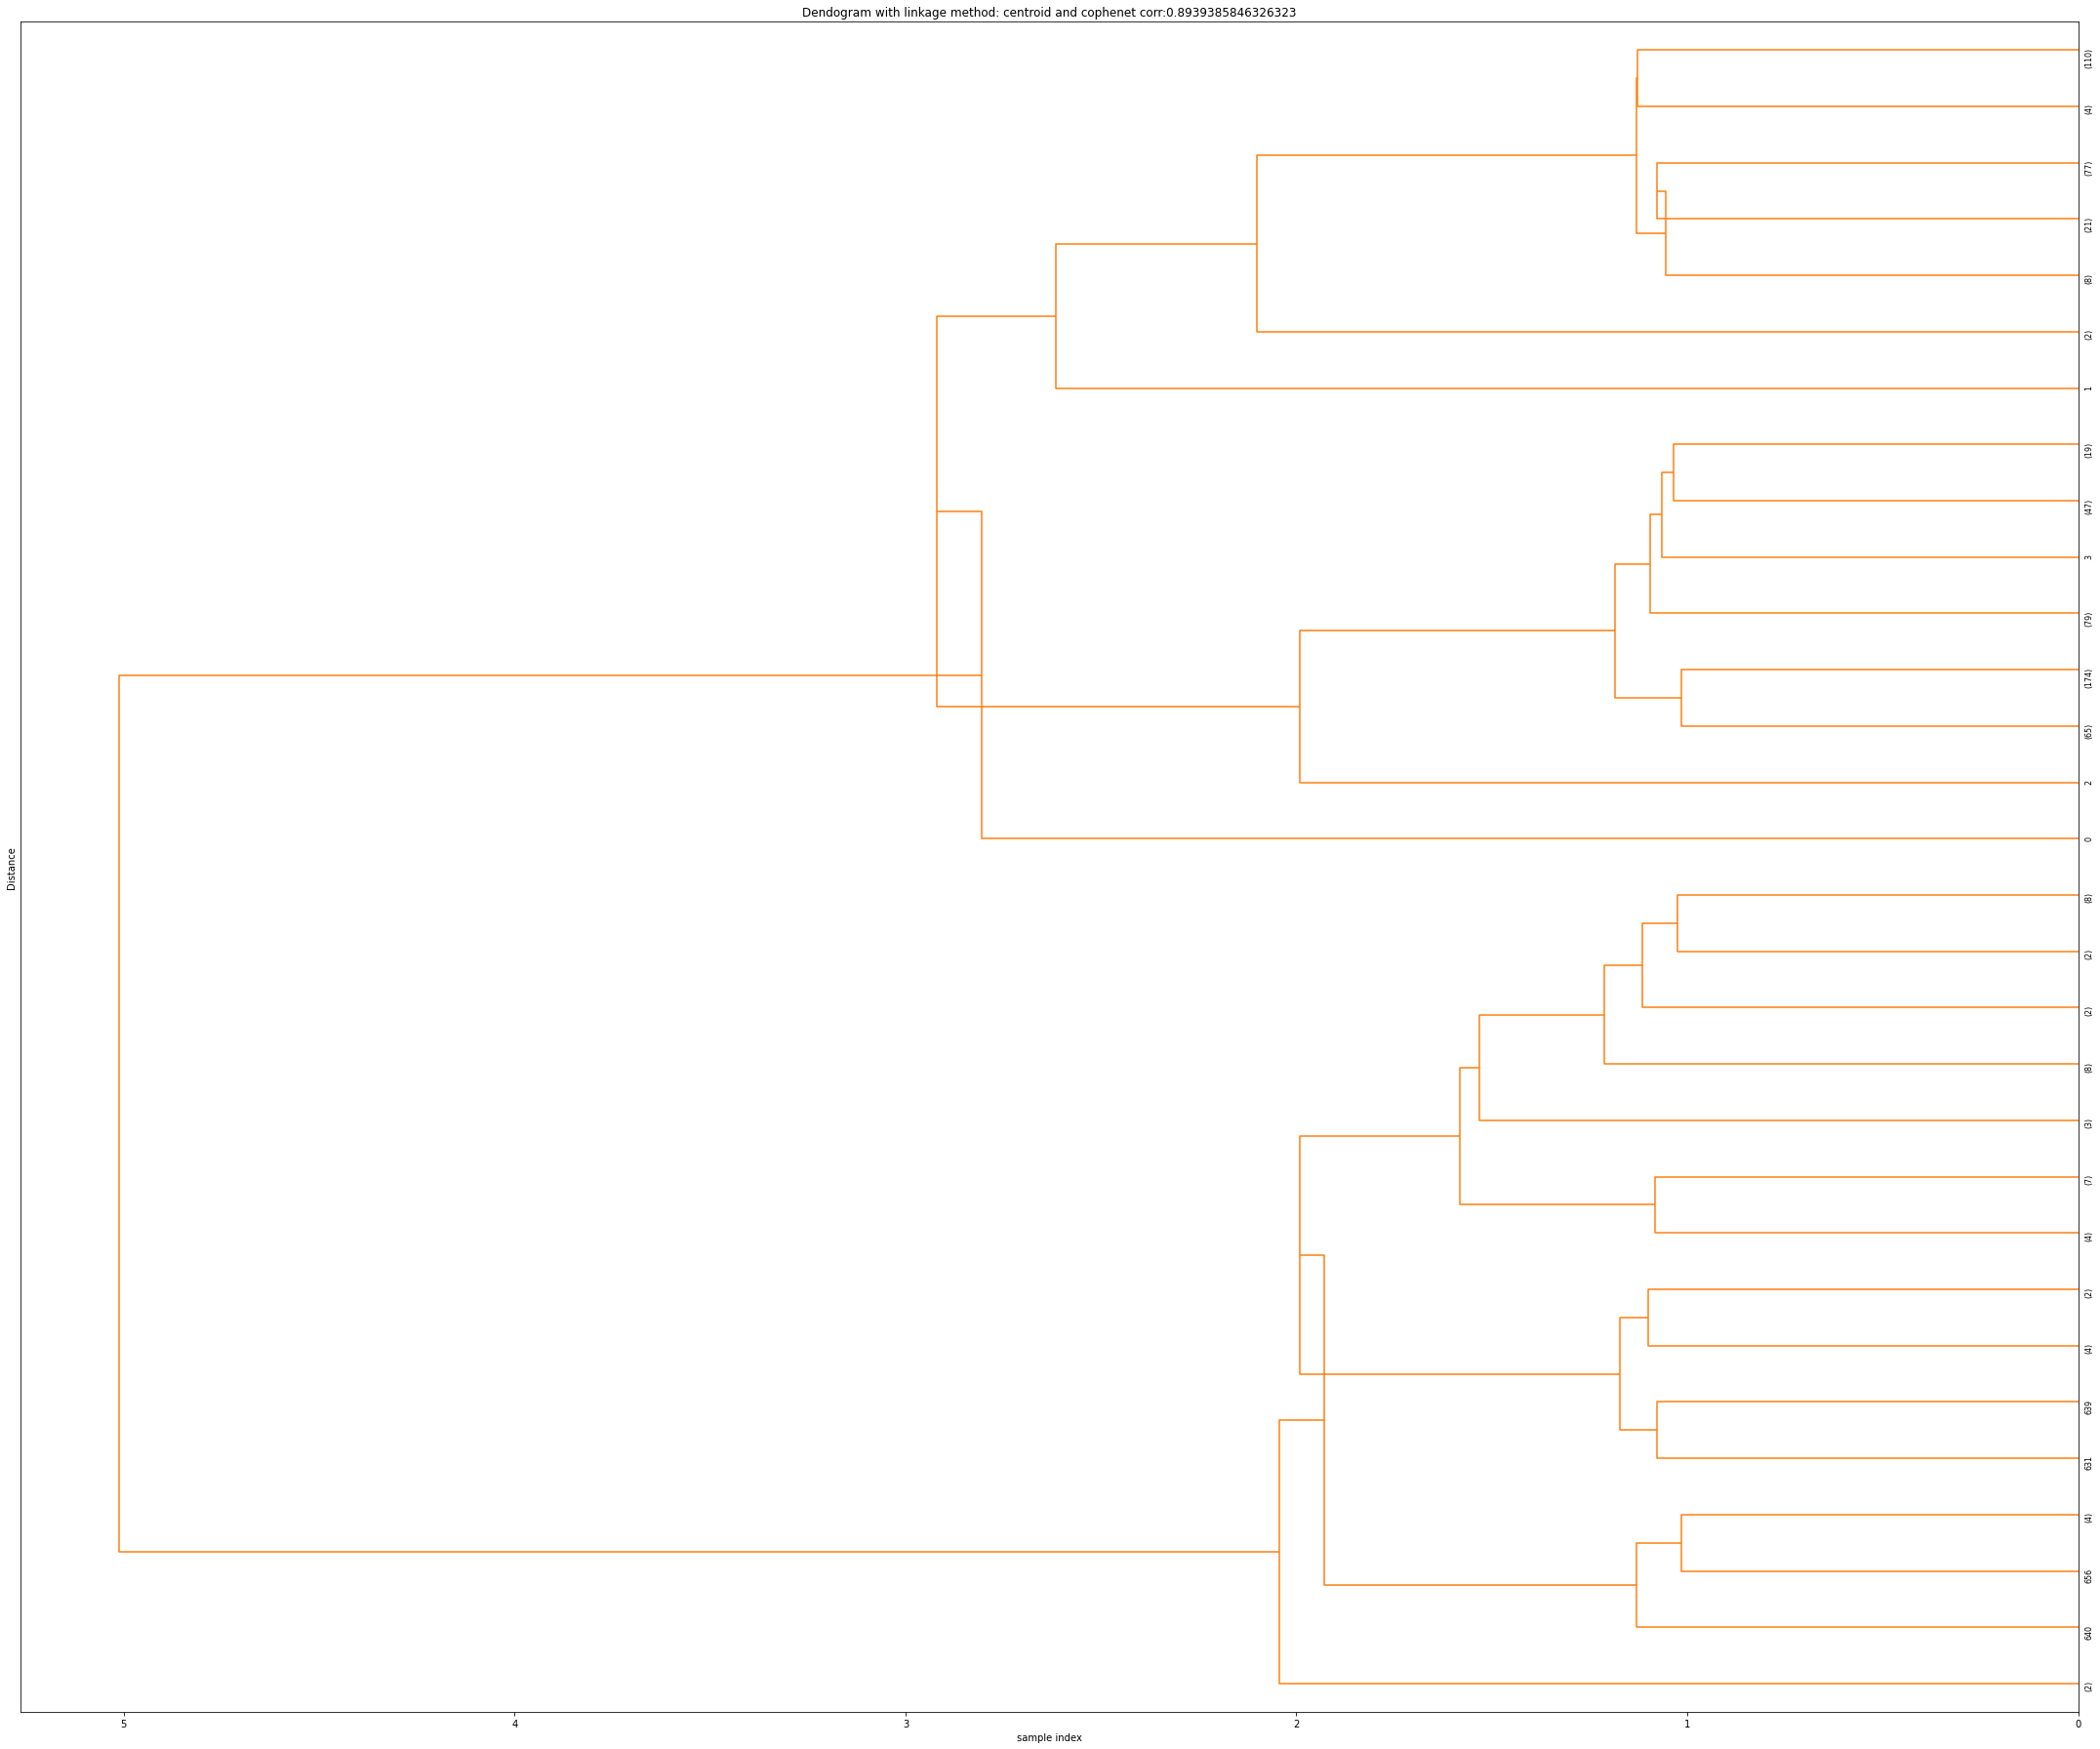

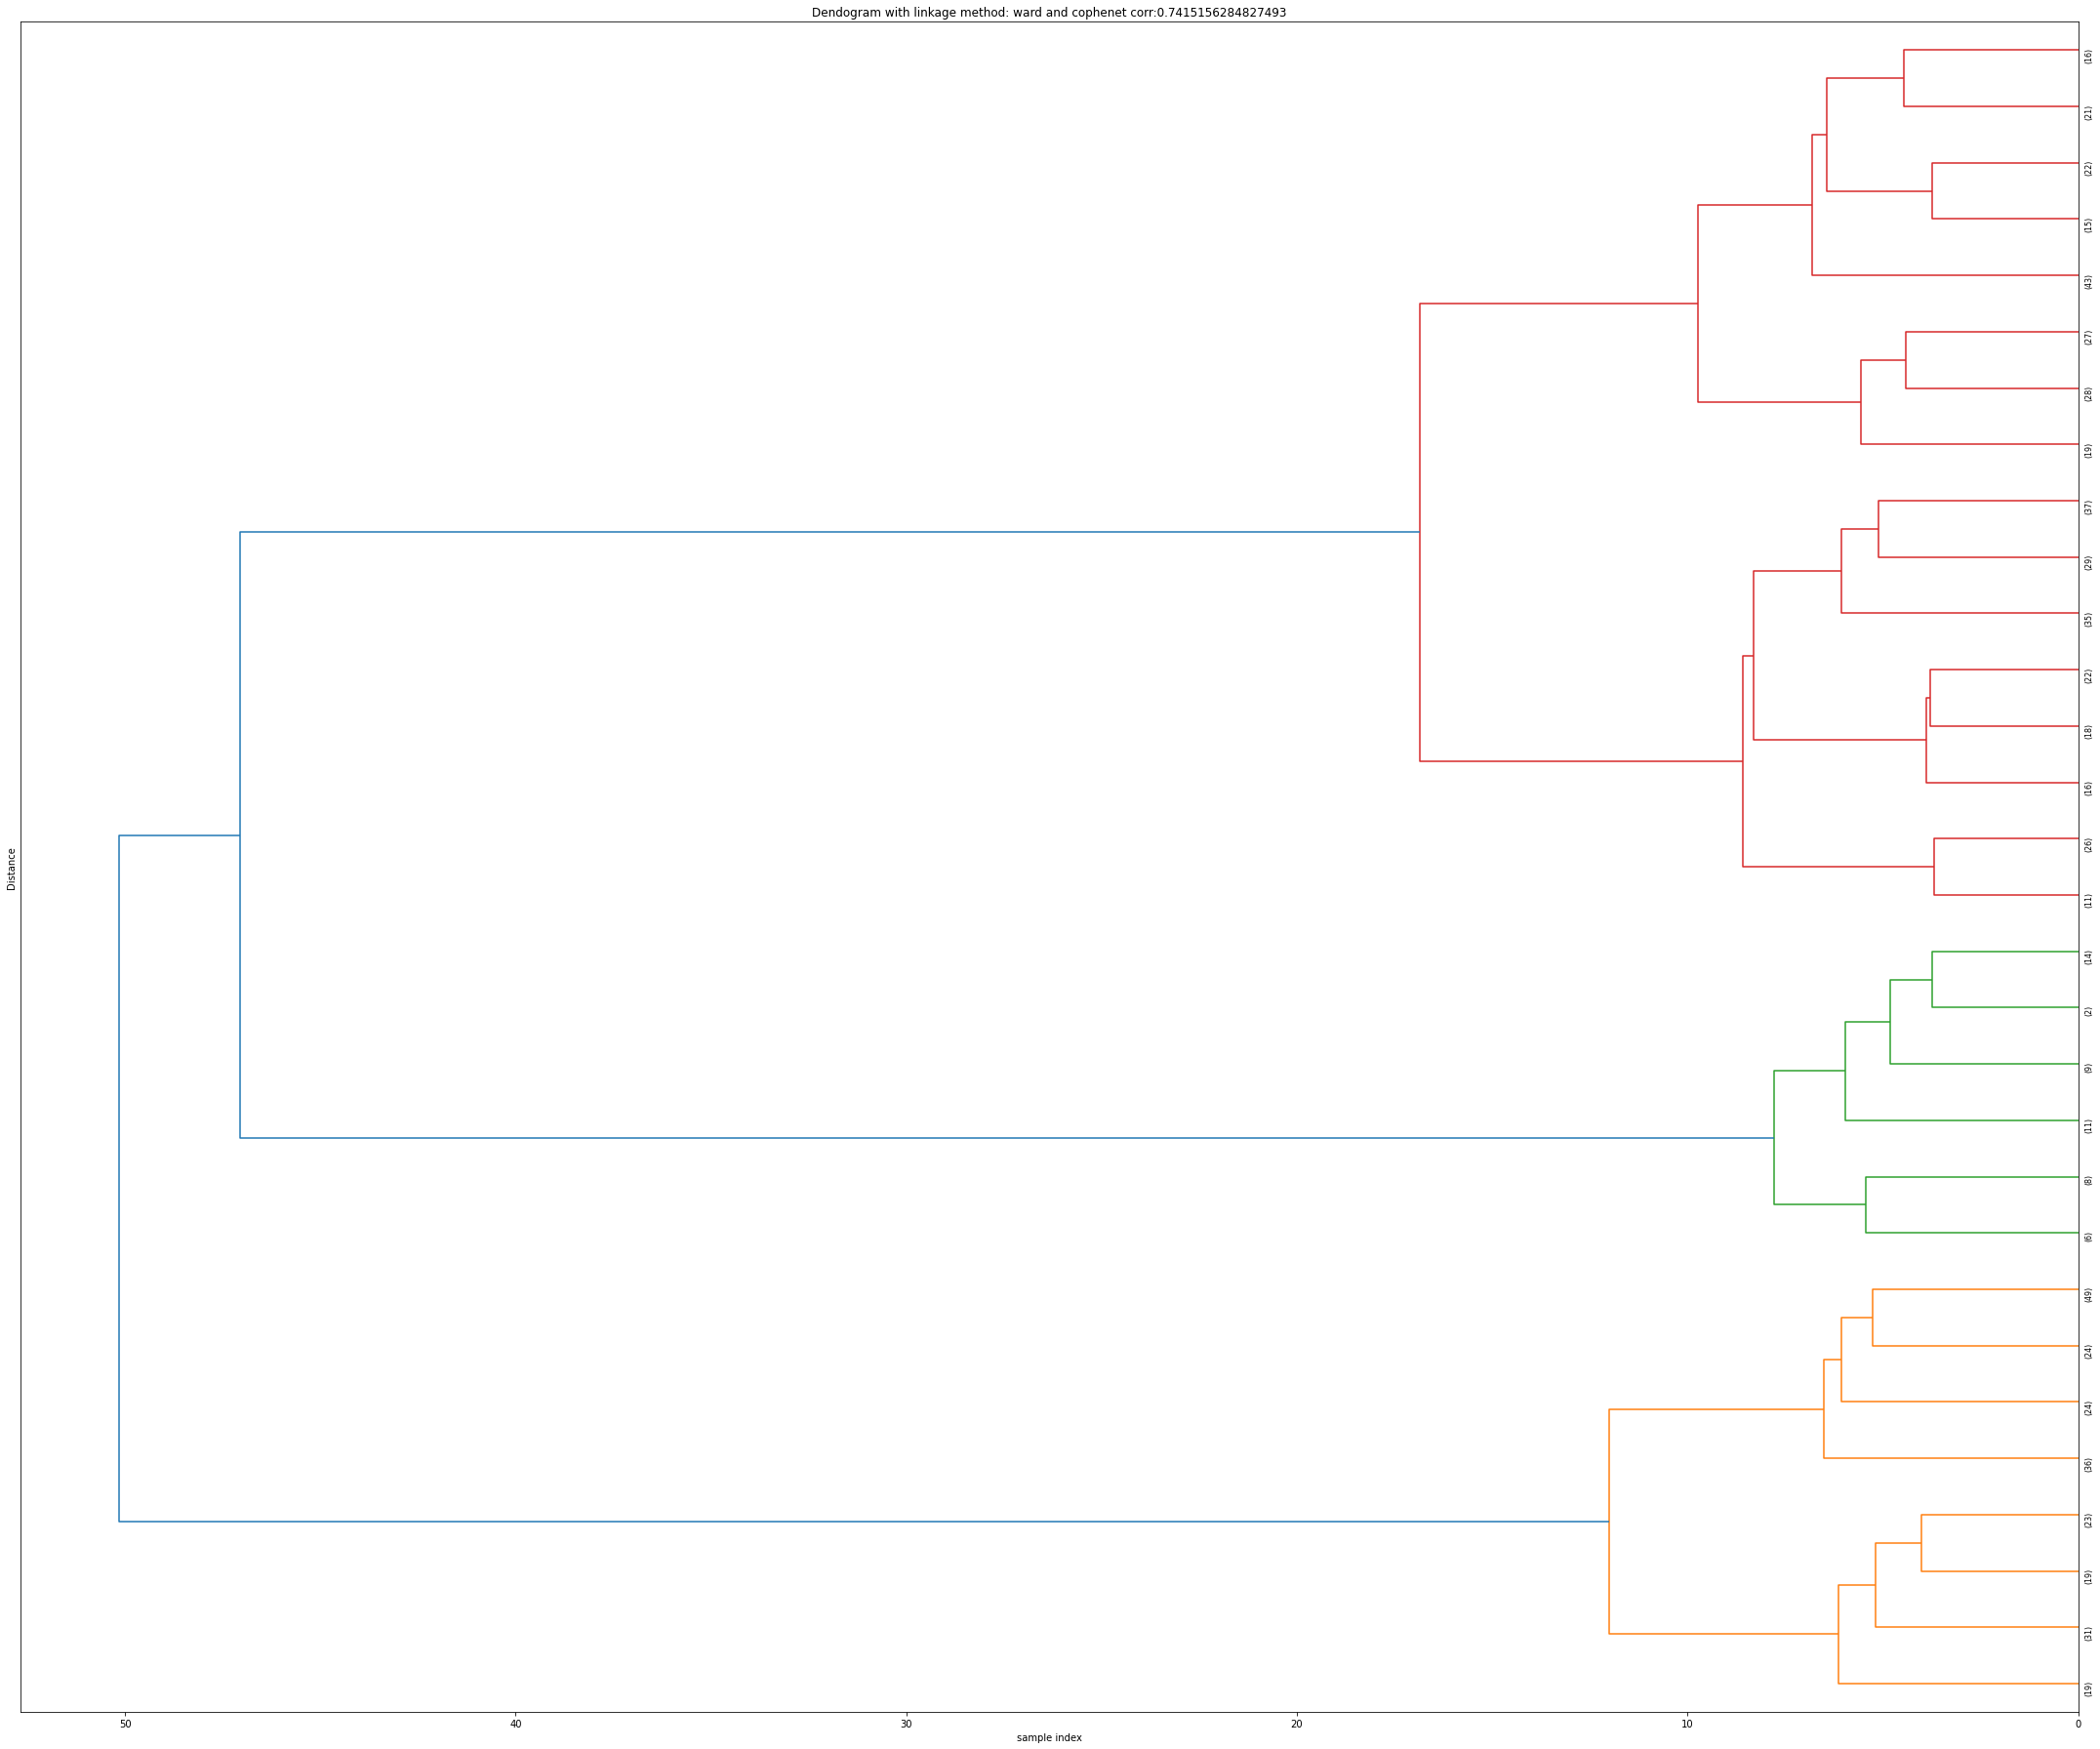

In [218]:
# The below function plots dendrogram for each linkage method by iterating though the list of linkage matrix that we
# calculated in the previous step
def plot_dendrograms(linkage_matrix_list):
    for matrix in linkage_matrix_list:
        plt.figure(figsize=(30, 25))
        plt.title('Dendogram with linkage method: {} and cophenet corr:{}'.
                  format(matrix['method'], matrix['correlation']))
        plt.xlabel('sample index')
        plt.ylabel('Distance')
        
        # Plots the truncated dendrogram
        dendrogram(matrix['linkage_matrix'], 
                   leaf_rotation=90., 
                   color_threshold = 40, 
                   truncate_mode='lastp', 
                   orientation='left',
                   leaf_font_size=8. )
        plt.tight_layout()
        plt.show()
plot_dendrograms(linkage_matrix_list)

### Insights:

`The clusters and the distance scale is different for each linkage method`

In [219]:
# Display the cophenetic correlation for each linkage method
cophenet_corr_df

,Cophenetic Correlation
Hierarchial Clustering with single linkage Method,0.739122
Hierarchial Clustering with complete linkage Method,0.859973
Hierarchial Clustering with average linkage Method,0.897708
Hierarchial Clustering with centroid linkage Method,0.893939
Hierarchial Clustering with ward linkage Method,0.741516


### Insights:

`Higher value of cophenetic correlation indicates better segmentaion by the model. So we would choose Hierarchial clustering with 'euclidean' distance and 'average' linkage method as it has the highest cophenetic correlation 0.897708`

In [220]:
# Create a hierarchial clustering model with metric as 'euclidean' and linkage method as 'average'

linkage_matrix = linkage(X, metric='euclidean', method='average')
correlation, coph_dist = cophenet(linkage_matrix, pdist(X))
# fcluser creates clusters from linkage matrix based on the criteria and the threshold value passed in.
# Here we are using criteria as distance and the threshold as 3.2, so flcuster truncates the dendrogram
# at distance 3.2 and returns number of clusters at 3.2 distance 
clusters = fcluster(linkage_matrix, 3.2, criterion='distance')
clusters

array([3, 2, 3, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

# Boxplot of Hierarchial Cluster

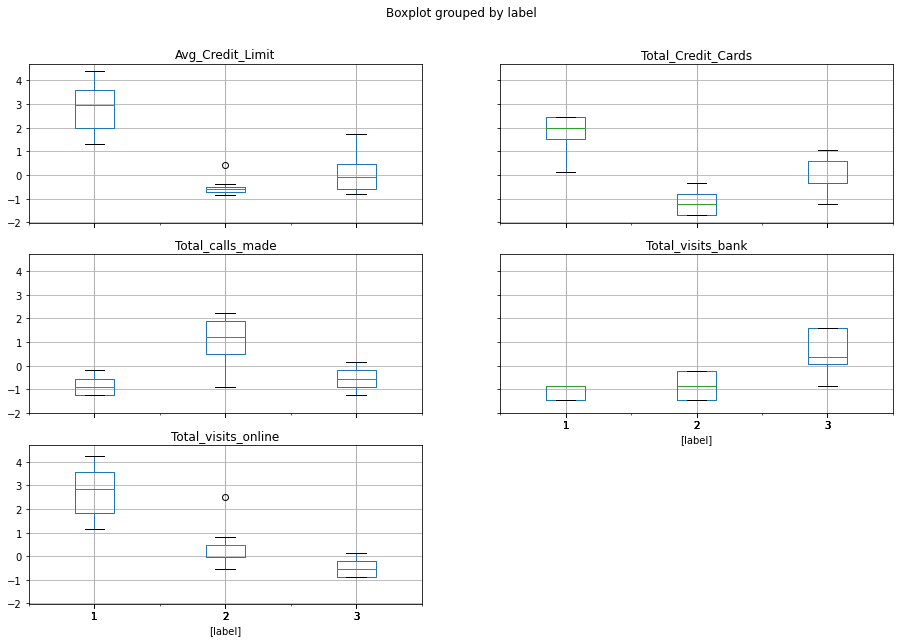

In [221]:
# Plot the boxplot of hierarchial clusters
def plot_boxplots(scaled_df, clusters):
    cust_data_scaled_for_label = scaled_df.copy()
    cust_data_scaled_for_label['label'] = clusters
    cust_data_scaled_for_label.boxplot(by='label', figsize=(15,10))
    plt.show()
plot_boxplots(X, clusters)

### Insights:

`The clusters in the hierarchial boxplot looks lot similar to the clusters from KMeans. Except that the labeling with KMeans starts from 0 where as in hierarchial, it starts from 1.`

<ol>
<li> Customers who uses online quite a lot(those belong to label 1) are the ones that has higher credit limit, has higher number of credit cards. They make phone calls to the bank less of number of times compared other customers and visits bank very rarely.</li>
<br />

<li> Customers who makes phone calls a lot(those belong to label 2) are the ones with less credit limit, has low number of credit cards. They visit online and bank sometimes.</li>
<br />

<li> Customers who visits the bank more often(those belong to lable 3) are the ones with medium range of credit limit, medium number of credit cards. They use online facility very less and makes phone calls sometimes.</li>
</ol>

# Hierarchial Clustering Silhouette Score

In [222]:
# calculate silhouette score and update results_df with both silhouette score
def find_silhouette_score(scaled_df, clusters, method_name, results_df):
        results_df.loc[method_name] = [silhouette_score(scaled_df, clusters, 
                                                        metric='euclidean', 
                                                        random_state=7  
                                                        )]
method_name = 'Hierarchial Clustering with average linkage Method'
find_silhouette_score(X, clusters, method_name, results_df)
results_df

,silhouette score
KMeans Cluster,0.515718
Hierarchial Clustering with average linkage Method,0.515922


# Hierarchial Clustering Using Sklearn

In [223]:
# The perform_hierarchial_clustering_using_Agglomerative function does the following:
#     1. Takes dataframe, affinity, list of linkage methods and results dataframe as inputs
#     2. Creates AgglomerativeClustering model with 3 clusters for each linkage method
#     3. Finds the silhouette score for each linkage method and updates the results dataframe with the score

def perform_hierarchial_clustering_using_Agglomerative(df, affinity, linkage_methods, results_df):
    for linkage in linkage_methods:
        model = AgglomerativeClustering(n_clusters=3, affinity=affinity, linkage=linkage)
        model.fit(X)
        method_name = 'AgglomerativeClustering with {} linkage methog'.format(linkage)
        find_silhouette_score(X, model.labels_, method_name, results_df )

# create list of linkage methods
linkage_methods = ['single', 'complete', 'average','ward']
# execute above method
perform_hierarchial_clustering_using_Agglomerative(X, 'euclidean', linkage_methods, results_df)
# display the results dataframe
results_df

,silhouette score
KMeans Cluster,0.515718
Hierarchial Clustering with average linkage Method,0.515922
AgglomerativeClustering with single linkage methog,0.374289
AgglomerativeClustering with complete linkage methog,0.502644
AgglomerativeClustering with average linkage methog,0.515922
AgglomerativeClustering with ward linkage methog,0.514764


### Insights:

`There is no difference between silhouette scores using sklearn's Agglomerative clustering and scipy's Hierarchial clustering`

### Comparing KMeans and Hierarchial Clustering:

<ol>
<li> Based on the silhouette scores, both hierarchial clustering with 'average' linkage method and Kmeans clustering have almost have the same silhouette score with very negligible increase with hierarchial clustering.</li>
<br />

<li> Since hierarchial clustering calculates the distance between each pair of data points, it is computationally intensive when compared to KMeans. Even though hierarchial clustering has higher (which is very small difference) silhouette score, I am going to use KMeans which does far less computations to come up with same silhouette score.</li>
    
<o/>

In [224]:
# Assign the clusters formed by KMeans to the original dataset
cust_data['labels'] = kmc.labels_
# View the dataset head after assigning the labels
cust_data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,labels
0,1,87073,100000,2,1,1,0,0
1,2,38414,50000,3,0,10,9,1
2,3,17341,50000,7,1,3,4,0
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,2


### Insights:

` If we look at customers 87073 and 47437, They both have same average credit limit but ended up in 2 different groups. This tells us that the algorithm did not get influenced only by average credit limit since we scaled the data.` 

In [225]:
# Find out the mean by grouping the labels
cust_data.groupby('labels').mean()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,,,
0,417.528497,54881.329016,33782.383420,5.515544,3.489637,0.981865,2.000000
1,117.857143,55239.830357,12174.107143,2.410714,0.933036,3.553571,6.870536
2,611.280000,56708.760000,141040.000000,8.740000,0.600000,10.900000,1.080000


# Insights:

`The clusters are formed based on the average credit limit(high, medium and low) and the mode of contact (online, phone and in-person)`

In [226]:
# Finding out records with duplicate Customer Keys with labels
duplicate_customer_keys_with_labels = cust_data.groupby('Customer Key').filter(lambda x: len(x) > 1 )
duplicate_customer_keys_with_labels.groupby(['Customer Key', 'labels']).mean()

Sl_No  Avg_Credit_Limit  Total_Credit_Cards  \
Customer Key labels                                                
37252        0       433.0           59000.0                 6.0   
             1        49.0            6000.0                 4.0   
47437        0       333.0           17000.0                 7.0   
             2         5.0          100000.0                 6.0   
50706        0       477.0           52000.0                 5.5   
96929        0       395.5           40000.0                 5.0   
97935        1       105.0           17000.0                 2.0   
             2       633.0          187000.0                 7.0   

                     Total_visits_bank  Total_visits_online  Total_calls_made  
Customer Key labels                                                            
37252        0                     2.0                  1.0               2.0  
             1                     0.0                  2.0               8.0  
47437        0                     3.0                  1.0               0.0  
             2                     0.0                 12.0               3.0  
50706        0                     5.0                  1.0               2.0  
96929        0                     3.5                  1.0               1.0  
97935        1                     1.0                  2.0              10.0  
             2                     1.0                  7.0               0.0

### Insights:

<ol>
<li> As we observed initially the customer with key 47437, initially in the group of 2 (customers with higher credit limit) and ended up in the group of 0 (customers with medium range of credit limit)</li>
<br />

<li> Similar cluster movement happend with customers 37252 and 97935</li>
<br />

<li> The customers 50706 and 96929 did not change the clusters, for which we initally thought that they would move from one cluster to another.</li>
</ol>

# Key Questions:

## 1.How many different segments of customers are there?

` There are 3 segments of customers`

## 2.How are these segments different from each other?

`We have the following 3 segments of customers`

##### a. Customers with High average credit limit: 
        These customers use higher number of credit cards, uses online banking a lot, makes phone calls to the bank sometimes and very rarely visits the bank in person.


##### b. Customers with medium range of average credit limit: 
        These customers use medium number of credit cards, doesn't use online banking that much, makes phone calls to the bank sometimes and visits the bank in person too.

##### c. Customers with low average credit limit:
        These customers use less number of credit cards, uses online banking more often than the customers with medium range of credit limit, makes phone calls to the bank more often and very rarely visits the bank in person.

## 3.What  are  your recommendations  to  the  bank  on  how  to  better  market  to  and service these customers?

### Recommendations for Sales:

<ol>

<li> For new and existing customers with higher credit limit, bank can send new promotions via it's online customer portal and email as these customers are like to interact with the bank using internet. Bank can target these customers for products like Secured loans (ex: Homeequity line of credit) or unsercured loans (ex: personal loans) as these customers have higher credit limit which intern means low risk customers in the bank's prespective.</li>
<br />

<li> To target new and existing customers with average/medium range of credit limit, bank can have new promotions displayed on the premises of each branch as majority of these customers are willing to visit the bank in person. Bank can promote for credit limit increase for the people who falls into this group and has upper end of credit limit. Bank employees needs to be trained to explain the new promotions to the people who visits the bank.</li>
<br />

<li> For customers with low credit limit, bank can send promitions using it's customer portal and email as some customers are like to interact with bank via internet. Bank need to train their customer support team as well as sales team in the back office to explain their new products and promotions as majority of the people in this category are willing to make phone calls to the bank. Bank should promote products like loans with collateral.</li> 

</ol>


### Recommendations for Operations Team:

<ol>
<li> Bank need to upgrade thier online customer portal's software keeping in mind of customer's ease of use. The system should have FAQ's page which address majority of general queries. The system should have customer chat option with both AI enabled and with option of connecting to the human representative. It would also help the customers if the system has a provision of raising/submitting the query through thier customer portal.</li>
<br />

<li> To address the customer queries who makes phone calls to customer service, bank needs to train their operations team, provide check list of solutions for most common problems so that the customer's quries can be resolved faster. Bank can also have automated system to address queries like 'What is my outstanding balance?'</li>
<br />

<li> Train the bank employess at every branch to address their customer needs that visits the bank in person.</li>
</ol>